# XGBoost

* 트리 기반의 앙상블 기법
* 분류에 있어서 다른 알고리즘보다 좋은 예측 성능을 보여줌
* XGBoost는 GBM 기반이지만, GBM의 단점인 느린 수행 시간과 과적합 규제 부재 등의 문제를 해결
* 병렬 CPU 환경에서 빠르게 학습 가능

In [73]:
from sklearn.datasets import load_iris, load_breast_cancer, load_boston, load_diabetes, load_wine
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

# xgboost는 sklearn에 포함되어 있지 않으나, 별도의 sklearn에 랩핑되어 있다. 
# 이에, 편한거 가져다가 쓰면 된다. 왜 이렇게 되어 있는지는 모르겠다. 
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance, plot_tree

import graphviz
import matplotlib.pyplot as plt
plt.style.use(["seaborn-whitegrid"])

## 파이썬 기반 XGBoost

In [56]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [57]:
params = {
  "max_depth" : 3, # default는 6으로 설정되어 있으며, 트리구조이기 때문에 깊이를 조절할 수 있음 
  "eta" : 0.1, # 과적 합을 방지하기 위해 업데이트에 사용되는 단계 크기 축소입니다. 각 부스팅 단계 후에는 새로운 기능의 가중치를 직접 가져올 수 있으며 eta는 기능 가중치를 줄여 부스팅 프로세스를보다 보수적으로 만듭니다.
  "objective" : "binary:logistic", 
  "eval_metric" : "logloss", # 검증 데이터에 대한 평가 메트릭, 기본 메트릭은 목표에 따라 할당됩니다 (회귀의 경우 rmse, 분류의 경우 logloss, 순위의 평균 정밀도).
  "early_stopping" : 100 
}

num_rounds = 400

In [58]:
evals = [(dtrain, "train"), (dtest, "test")]

xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,
                      early_stopping_rounds=100, evals=evals )

[0]	train-logloss:0.609605	test-logloss:0.614431
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540756	test-logloss:0.547208
[2]	train-logloss:0.484075	test-logloss:0.495585
[3]	train-logloss:0.433243	test-logloss:0.446594
[4]	train-logloss:0.389845	test-logloss:0.406818
[5]	train-logloss:0.352124	test-logloss:0.370823
[6]	train-logloss:0.31949	test-logloss:0.340322
[7]	train-logloss:0.291385	test-logloss:0.315586
[8]	train-logloss:0.266061	test-logloss:0.291813
[9]	train-logloss:0.243922	test-logloss:0.27323
[10]	train-logloss:0.22408	test-logloss:0.2549
[11]	train-logloss:0.206975	test-logloss:0.242168
[12]	train-logloss:0.191283	test-logloss:0.225769
[13]	train-logloss:0.177047	test-logloss:0.212827
[14]	train-logloss:0.16451	test-logloss:0.199469
[15]	train-logloss:0.153192	test-logloss:0.191686
[16]	train-logloss:0.14312	test-logloss:0.180686
[17]	train-loglos

In [59]:
import numpy as np
predicts = xgb_model.predict(dtest)
np.round(predicts[:10], 3)

array([0.995, 0.   , 0.   , 1.   , 1.   , 0.   , 0.001, 0.065, 0.346,
       1.   ], dtype=float32)

In [60]:
preds = [1 if x > 0.5 else 0 for x in predicts]
preds[:10]

[1, 0, 0, 1, 1, 0, 0, 0, 0, 1]

In [61]:
print(accuracy_score(y_test, preds))
print(precision_score(y_test, preds))
print(recall_score(y_test, preds))

0.9736842105263158
0.9722222222222222
0.9859154929577465


일반적인 방법으로 학습을 진행해봄

In [62]:
model = XGBRegressor()
model.fit(X_train, y_train)

[05:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [63]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9931020491295244
0.8646693033673498


In [64]:
preds = model.predict(X_test)


for  x in [0.3,0.5,0.7,0.9]:

  preds = [1 if i >= x else 0 for i in preds]
  print("threshold :", x)
  print(accuracy_score(y_test, preds))
  print(precision_score(y_test, preds))
  print(recall_score(y_test, preds))
  print("-"*10)

threshold : 0.3
0.9649122807017544
0.958904109589041
0.9859154929577465
----------
threshold : 0.5
0.9649122807017544
0.958904109589041
0.9859154929577465
----------
threshold : 0.7
0.9649122807017544
0.958904109589041
0.9859154929577465
----------
threshold : 0.9
0.9649122807017544
0.958904109589041
0.9859154929577465
----------


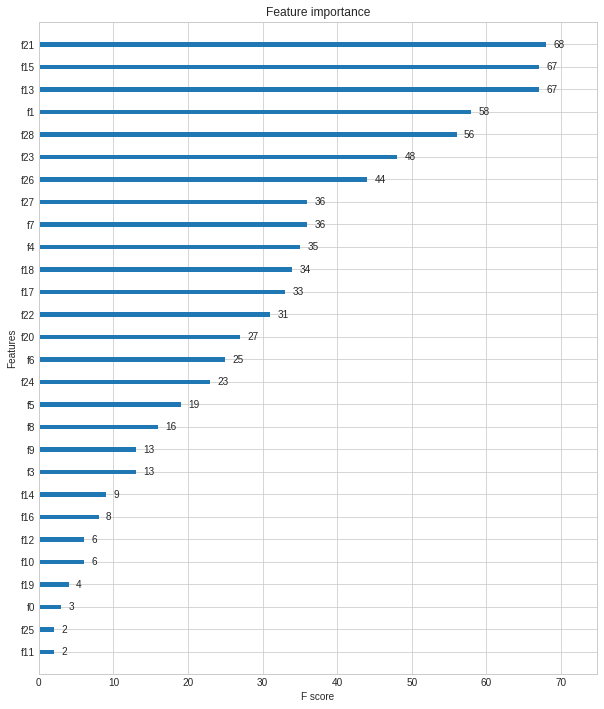

In [65]:
# 어떤 feature가 영향을 높게 주는지를 알 수 있도록 시각화 

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax);

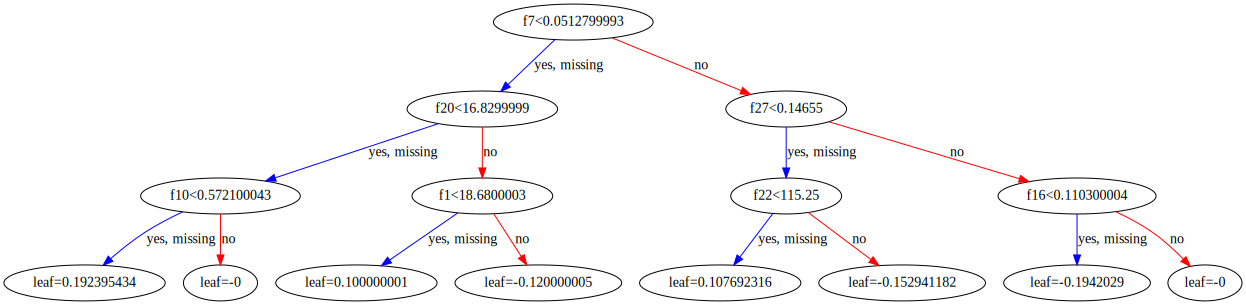

In [66]:
dot_data = xgb.to_graphviz(xgb_model)
graph = graphviz.Source(dot_data)
graph

## XGBClassifier

### 붓꽃 데이터

In [67]:
iris =load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=iris.target)

In [68]:
xgbc = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgbc.fit(X_train, y_train)
preds =xgbc.predict(X_test)
preds_proba = xgbc.predict_proba(X_test)[:,1]

In [69]:
cross_validate(
    estimator = xgbc,
    X = iris.data, y=iris.target,
    cv = 5
)

{'fit_time': array([0.05170512, 0.05243659, 0.04841065, 0.05024385, 0.05373096]),
 'score_time': array([0.00108075, 0.00098014, 0.00092769, 0.00124478, 0.00096726]),
 'test_score': array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])}

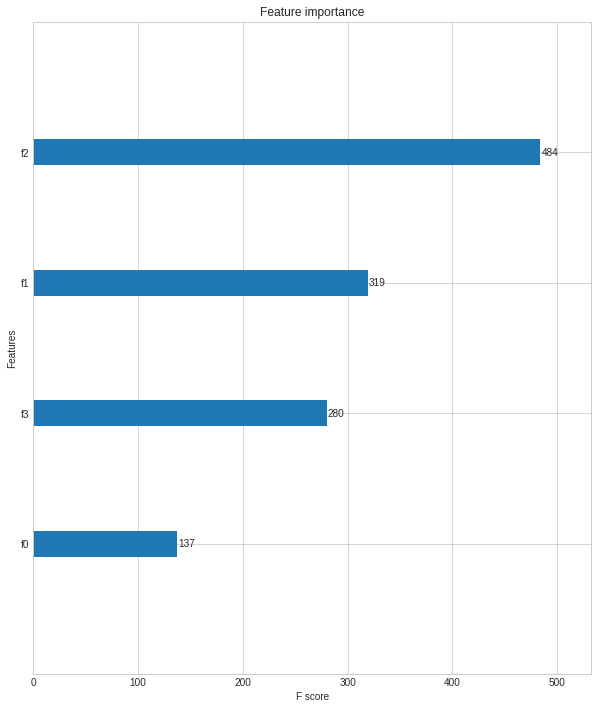

In [70]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgbc,ax=ax);

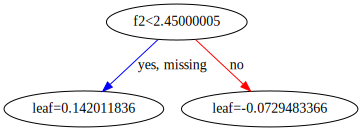

In [71]:
dot_data = xgb.to_graphviz(xgbc)
graph = graphviz.Source(dot_data)
graph

### 와인 데이터

In [74]:
wine =load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=wine.target)

In [75]:
xgbc = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgbc.fit(X_train, y_train)
preds =xgbc.predict(X_test)
preds_proba = xgbc.predict_proba(X_test)[:,1]

In [78]:
cross_validate(
    estimator = xgbc,
    X = wine.data, y=wine.target,
    cv = 5
)

{'fit_time': array([0.07574368, 0.07662654, 0.07159448, 0.0790689 , 0.07405066]),
 'score_time': array([0.00090861, 0.00096035, 0.00096059, 0.00091958, 0.00090837]),
 'test_score': array([0.97222222, 0.91666667, 0.94444444, 0.97142857, 1.        ])}

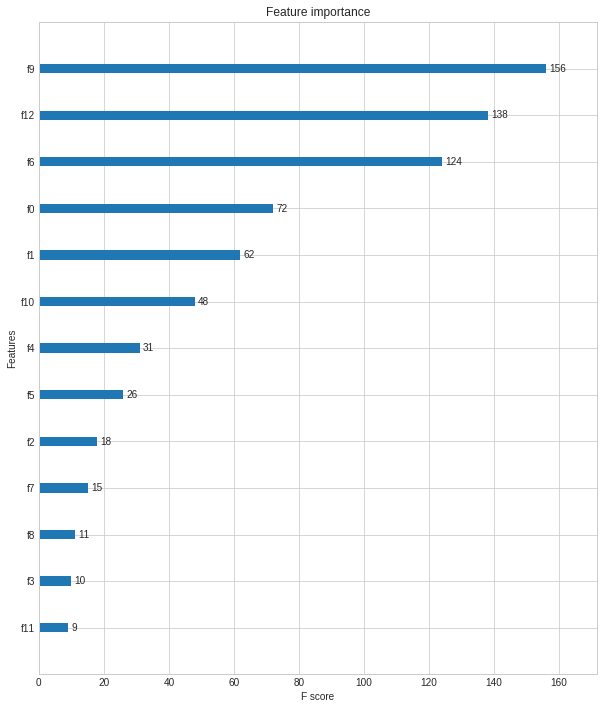

In [79]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgbc,ax=ax);

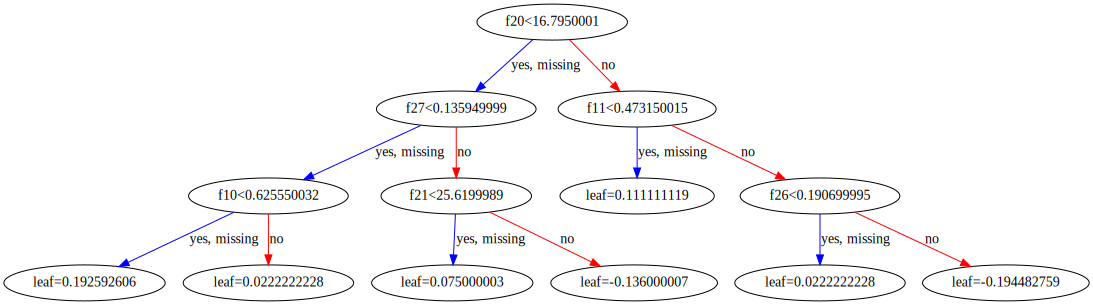

In [85]:
dot_data = xgb.to_graphviz(xgbc)
graph = graphviz.Source(dot_data)
graph

### 유방암 데이터

In [81]:
cancer =load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=cancer.target)

In [82]:
xgbc = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgbc.fit(X_train, y_train)
preds =xgbc.predict(X_test)
preds_proba = xgbc.predict_proba(X_test)[:,1]

In [83]:
cross_validate(
    estimator = xgbc,
    X = wine.data, y=wine.target,
    cv = 5
)

{'fit_time': array([0.07615328, 0.07307696, 0.0720005 , 0.07752657, 0.07767987]),
 'score_time': array([0.00093555, 0.00086069, 0.00085187, 0.00107574, 0.00093317]),
 'test_score': array([0.97222222, 0.91666667, 0.94444444, 0.97142857, 1.        ])}

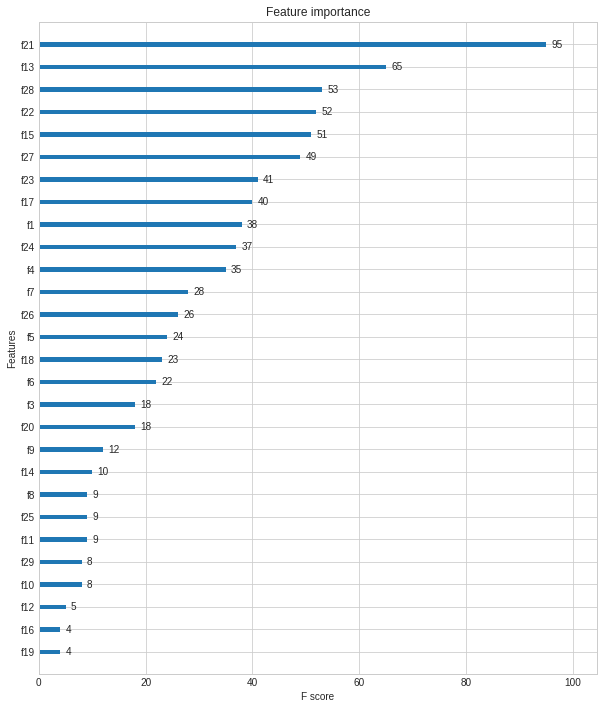

In [84]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgbc,ax=ax);

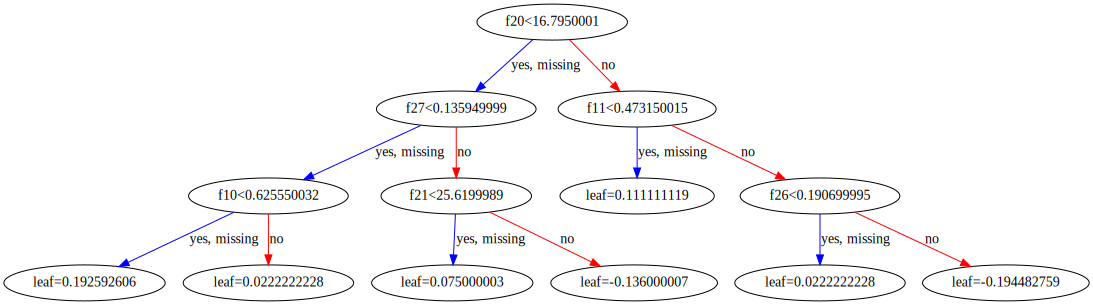

In [86]:
dot_data = xgb.to_graphviz(xgbc)
graph = graphviz.Source(dot_data)
graph

## XGBRegressor

### 보스턴 데이터

In [92]:
boston =load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, 
                                                    random_state=42, test_size=0.2,)

In [93]:
xgbr = XGBRegressor(n_estimators=400, learning_rate=0.1, max_depth=3, objective="reg:squarederror")
xgbr.fit(X_train, y_train)
preds =xgbr.predict(X_test)

In [95]:
cross_val = cross_validate(
    estimator = xgbr,
    X = boston.data, y=boston.target,
    cv = 5
)

print("avg test score", cross_val["test_score"].mean())

avg test score 0.6884390572208088


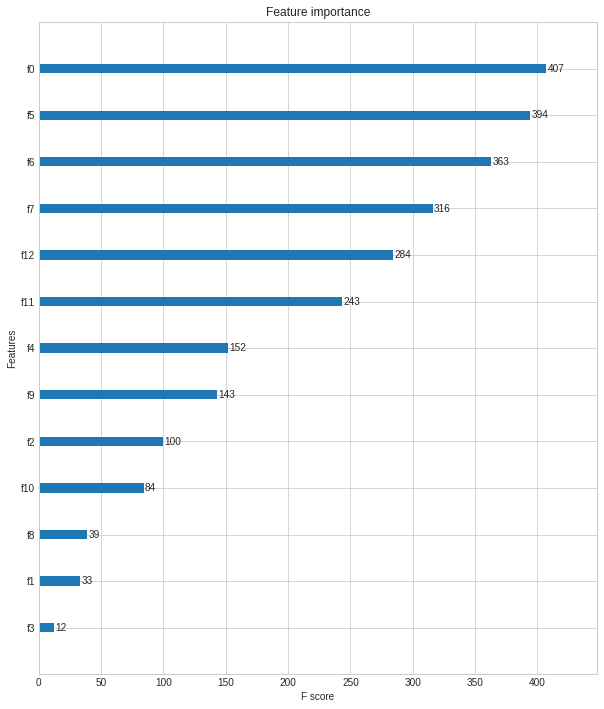

In [96]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgbc,ax=ax);

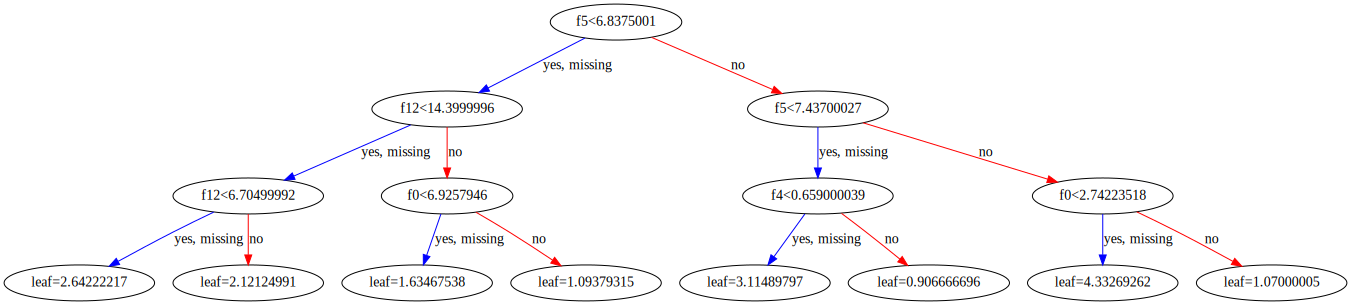

In [97]:
dot_data = xgb.to_graphviz(xgbr)
graph = graphviz.Source(dot_data)
graph

### 당뇨병 데이터

In [98]:
diabetes =load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, 
                                                    random_state=42, test_size=0.2,)

In [99]:
xgbr = XGBRegressor(n_estimators=400, learning_rate=0.1, max_depth=3, objective="reg:squarederror")
xgbr.fit(X_train, y_train)
preds =xgbr.predict(X_test)

In [102]:
cross_val = cross_validate(
    estimator = xgbr,
    X = diabetes.data, y=diabetes.target,
    cv = 5
)

print("avg test score", cross_val["test_score"].mean())

avg test score 0.3000529025802777


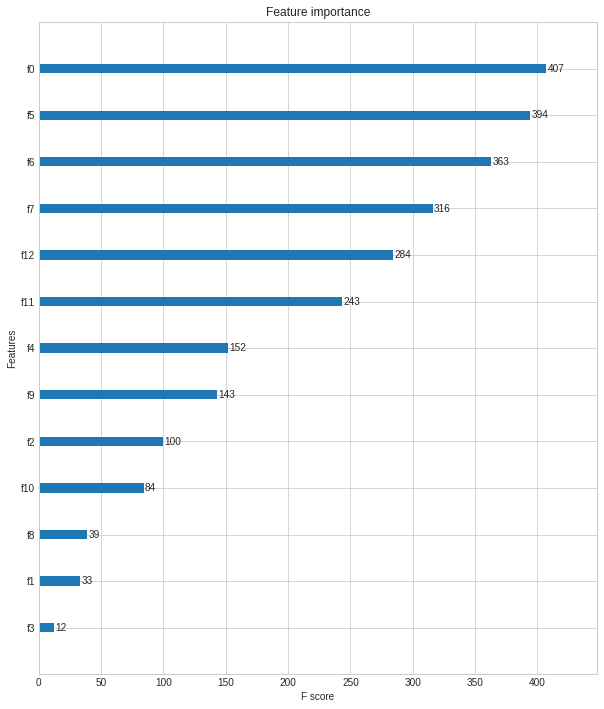

In [103]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgbc,ax=ax);

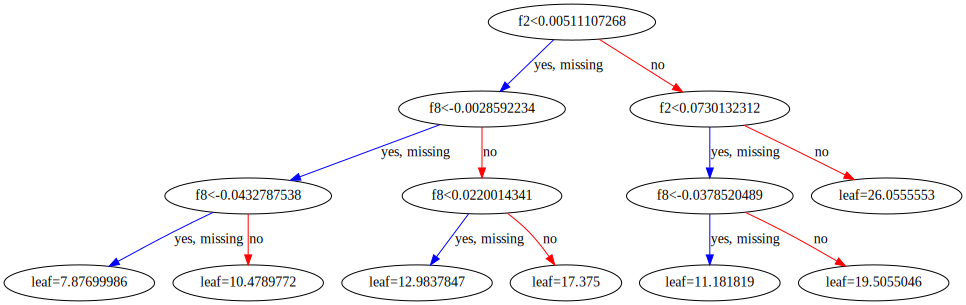

In [104]:
dot_data = xgb.to_graphviz(xgbr)
graph = graphviz.Source(dot_data)
graph

# LightGBM

* 빠른 학습과 예측 시간
* 더 적은 메모리 사용
* 범주형 특징의 자동 변환과 최적 분할

In [106]:
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree

## LGBMClassifier

### 붓꽃 데이터

In [107]:
iris =load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=iris.target)

In [ ]:
lgbmc = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbmc.predict(X_test)

In [112]:
cross_val = cross_validate(
    estimator = lgbmc,
    X = iris.data, y= iris.target,
    cv = 5
)

print("avg test score", cross_val["test_score"].mean())

avg test score 0.9533333333333335


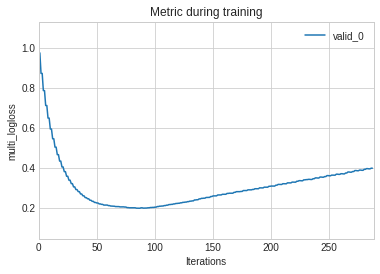

In [113]:
plot_metric(lgbmc)

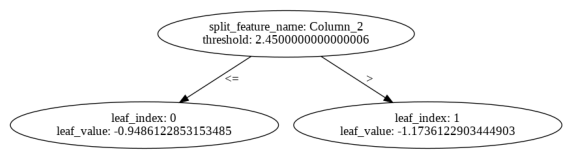

In [116]:
plot_tree(lgbmc, figsize=(10,12))

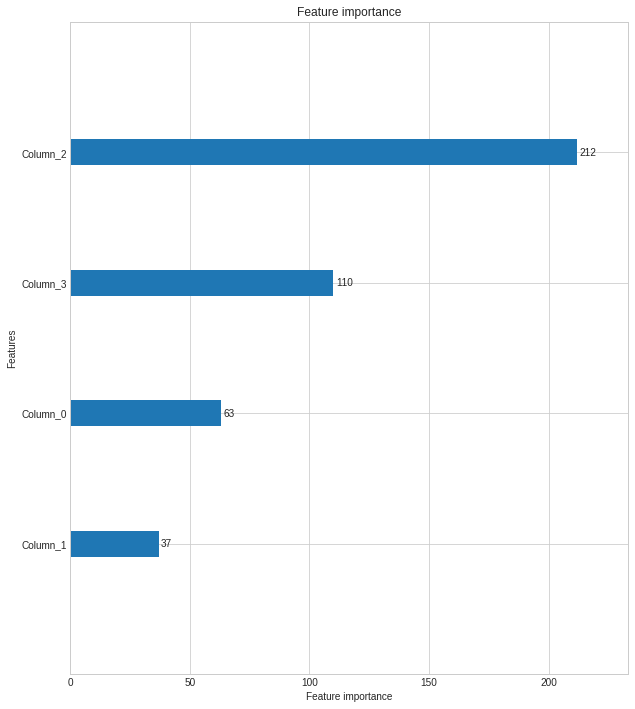

In [118]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbmc,ax=ax);

### 와인 데이터

In [122]:
wine =load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=wine.target)

lgbmc = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=False)
preds = lgbmc.predict(X_test)

cross_val = cross_validate(
    estimator = lgbmc,
    X = wine.data, y= wine.target,
    cv = 5
)

print("avg test score", cross_val["test_score"].mean())

avg test score 0.9720634920634922


### 유방암 데이터

In [123]:
cancer =load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=cancer.target)

lgbmc = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=False)
preds = lgbmc.predict(X_test)

cross_val = cross_validate(
    estimator = lgbmc,
    X = cancer.data, y= cancer.target,
    cv = 5
)

print("avg test score", cross_val["test_score"].mean())

avg test score 0.9701288619779536


## LGBMRegressor

### 보스턴 데이터

In [126]:
boston =load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, 
                                                    random_state=42, test_size=0.2,)

lgbmr = LGBMRegressor(n_estimators=400)
evals = [(X_test, y_test)]
lgbmr.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=False)
preds = lgbmr.predict(X_test)

cross_val = cross_validate(
    estimator = lgbmr,
    X = boston.data, y= boston.target,
    cv = 5
)

print("avg test score", cross_val["test_score"].mean())

avg test score 0.5692468252571979


### 당뇨병 데이터

In [127]:
diabetes =load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, 
                                                    random_state=42, test_size=0.2,)

lgbmr = LGBMRegressor(n_estimators=400)
evals = [(X_test, y_test)]
lgbmr.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=False)
preds = lgbmr.predict(X_test)

cross_val = cross_validate(
    estimator = lgbmr,
    X = diabetes.data, y= diabetes.target,
    cv = 5
)

print("avg test score", cross_val["test_score"].mean())

avg test score 0.30867643947179507
